In [1]:
#%%

import os

# os.chdir(os.path.dirname(__file__))
import numpy as np
import nonlincausality as nlc
import matplotlib.pyplot as plt
import copy
from nonlincausality.utils import prepare_data_for_prediction, calculate_pred_and_errors
from sklearn.svm import SVR

2024-12-12 10:34:27.321024: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:34:27.356578: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-12 10:34:27.356601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-12 10:34:27.357726: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-12 10:34:27.363593: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-12 10:34:27.364383: I tensorflow/core/platform/cpu_feature_guard.cc:1

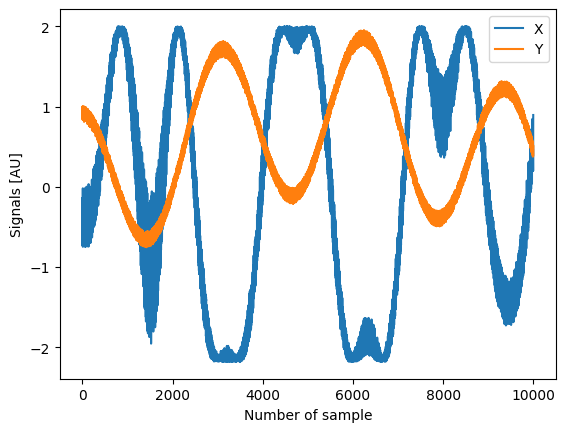

In [2]:
#%% Data generation Y->X

np.random.seed(10)
y = (
    np.cos(np.linspace(0, 20, 10_100))
    + np.sin(np.linspace(0, 3, 10_100))
    - 0.2 * np.random.random(10_100)
)
np.random.seed(20)
x = 2 * y ** 3 - 5 * y ** 2 + 0.3 * y + 2 - 0.05 * np.random.random(10_100)
data = np.vstack([x[:-100], y[100:]]).T

plt.figure()
plt.plot(data[:, 0], label="X")
plt.plot(data[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

Epoch 1/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0881 - mse: 0.0881 - val_loss: 0.0062 - val_mse: 0.0062
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0065 - mse: 0.0065 - val_loss: 0.0052 - val_mse: 0.0052
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0059 - val_mse: 0.0059
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0060 - val_mse: 0.0060
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0051 - val_mse: 0.0051
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0055 - val_mse: 0.0055
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0045 - val_mse: 0.0045
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

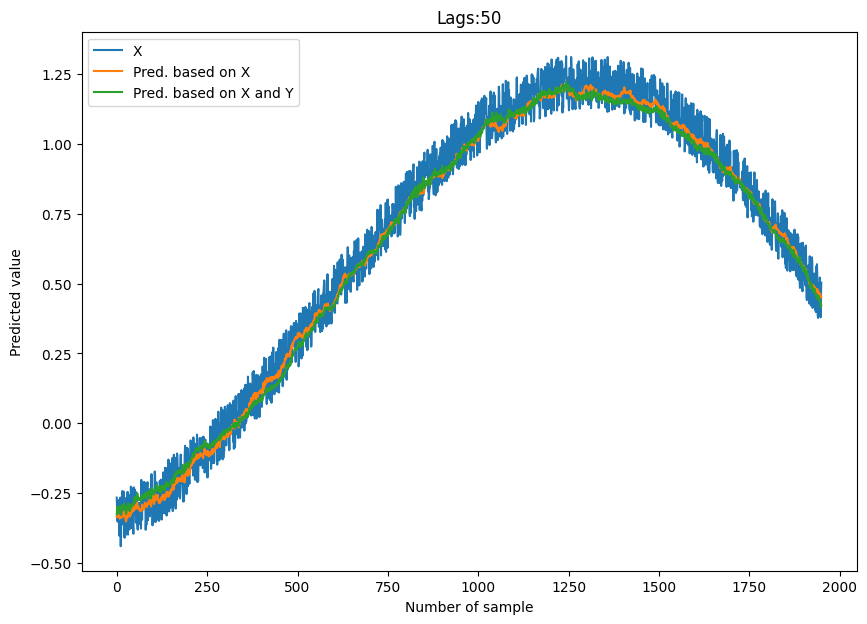

In [3]:
#%% Test in case of presence of the causality

lags = [50]
# data_train = data[:6000, :]
# data_val = data[6000:8000, :]
# data_test = data[8000:, :]
data_train = data[:6000, [1, 0]]
data_val = data[6000:8000, [1, 0]]
data_test = data[8000:, [1, 0]]

results = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

For lag = 50 Cohen's d = 0.036
Test statistic = 823651.0 p-value = 0.9999998517600667
61/61 [==============================] - 0s 1ms/step


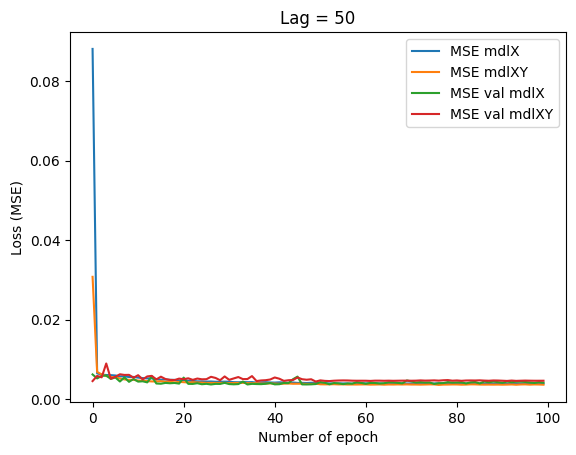

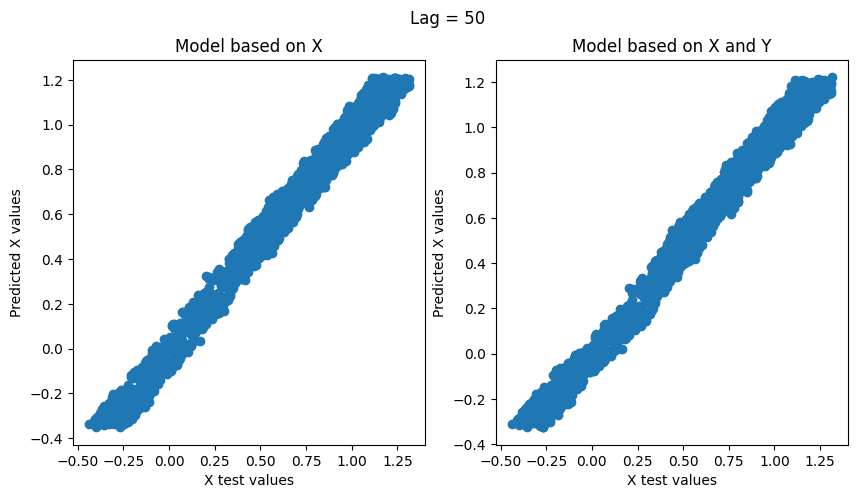

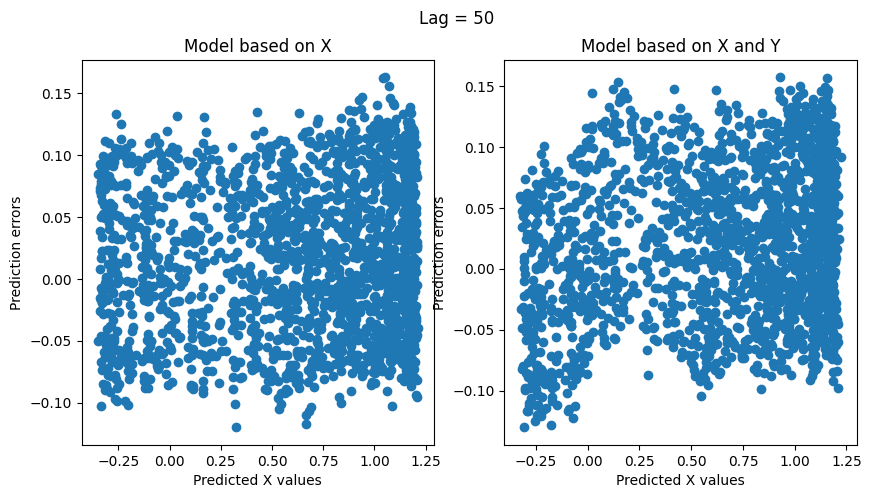

In [4]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X = results[lag].best_model_X
    best_model_XY = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag]._test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)
    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"Test statistic = {test_statistic} p-value = {p_value}")

    # Using models for prediction
    data_X, data_XY = prepare_data_for_prediction(data_test, lag)
    X_pred_X = best_model_X.predict(data_X)
    X_pred_XY = best_model_XY.predict(data_XY)

    # Plot of true X vs X predicted
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(data_test[lag:, 0], X_pred_X, "o")
    ax[0].set_xlabel("X test values")
    ax[0].set_ylabel("Predicted X values")
    ax[0].set_title("Model based on X")
    ax[1].plot(data_test[lag:, 0], X_pred_XY, "o")
    ax[1].set_xlabel("X test values")
    ax[1].set_ylabel("Predicted X values")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

    # Another way of obtaining predicted values (and errors)
    X_pred_X, X_pred_XY, error_X, error_XY = calculate_pred_and_errors(
        data_test[lag:, 0], 
        data_X, 
        data_XY, 
        best_model_X, 
        best_model_XY
    )
    # Plot of X predicted vs prediction error
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(X_pred_X, error_X, "o")
    ax[0].set_xlabel("Predicted X values")
    ax[0].set_ylabel("Prediction errors")
    ax[0].set_title("Model based on X")
    ax[1].plot(X_pred_XY, error_XY, "o")
    ax[1].set_xlabel("Predicted X values")
    ax[1].set_ylabel("Prediction errors")
    ax[1].set_title("Model based on X and Y")
    plt.suptitle("Lag = %d" % lag)

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0923 - mse: 0.0923 - val_loss: 0.0347 - val_mse: 0.0347
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0577 - mse: 0.0577 - val_loss: 0.0314 - val_mse: 0.0314
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0555 - mse: 0.0555 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0542 - mse: 0.0542 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0545 - mse: 0.0545 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

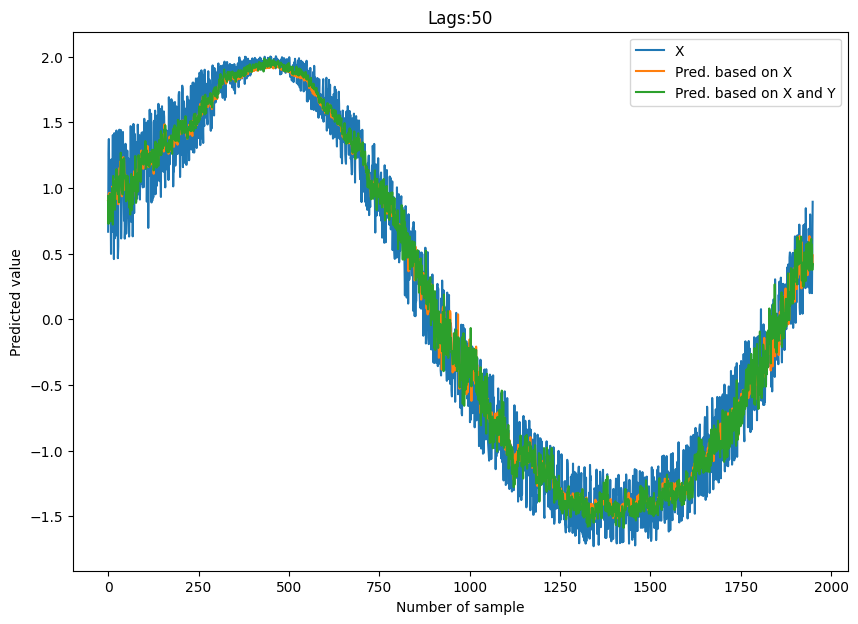

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.1167 - mse: 0.1167 - val_loss: 0.0291 - val_mse: 0.0291
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0527 - mse: 0.0527 - val_loss: 0.0299 - val_mse: 0.0299
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0516 - mse: 0.0516 - val_loss: 0.0292 - val_mse: 0.0292
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0517 - mse: 0.0517 - val_loss: 0.0300 - val_mse: 0.0300
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0501 - mse: 0.0501 - val_loss: 0.0342 - val_mse: 0.0342
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0499 - mse: 0.0499 - val_loss: 0.0303 - val_mse: 0.0303
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

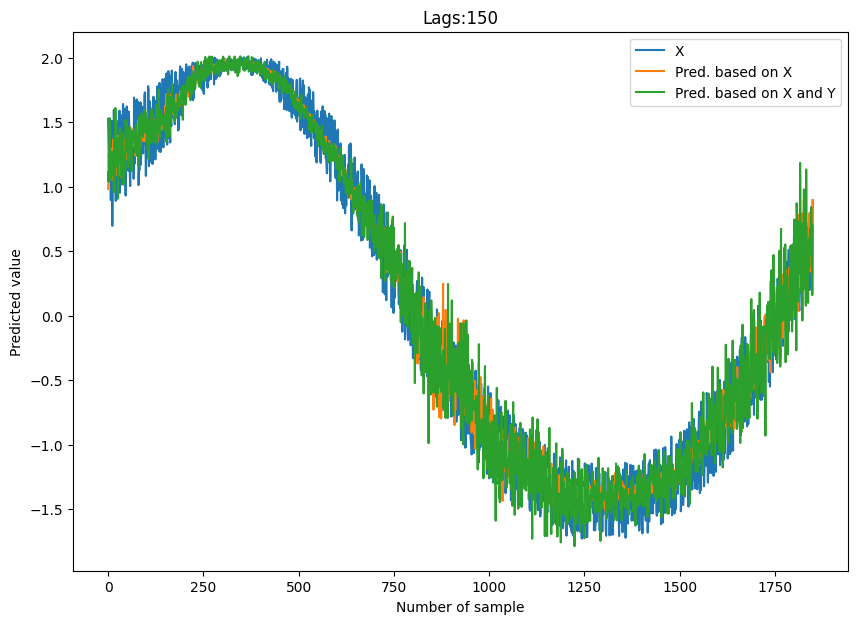

In [ ]:
#%% Test in case of absence of the causality

np.random.seed(30)
data_noise = np.vstack([x[:-100], np.random.random(10_000)]).T

lags = [50, 150]
data_noise_train = data_noise[:6000, :]
data_noise_val = data_noise[6000:8000, :]
data_noise_test = data_noise[8000:, :]

results = nlc.nonlincausalityNN(
    x=data_noise_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_noise_test,
    run=3,
    epochs_num=[50, 50],
    learning_rate=[0.001, 0.0001],
    batch_size_num=32,
    x_val=data_noise_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

For lag = 50 Cohen's d = 0.029
test statistic = 886494.0 p-value = 0.995318875558966
For lag = 150 Cohen's d = 0.113
test statistic = 676264.5 p-value = 0.9999999999999974


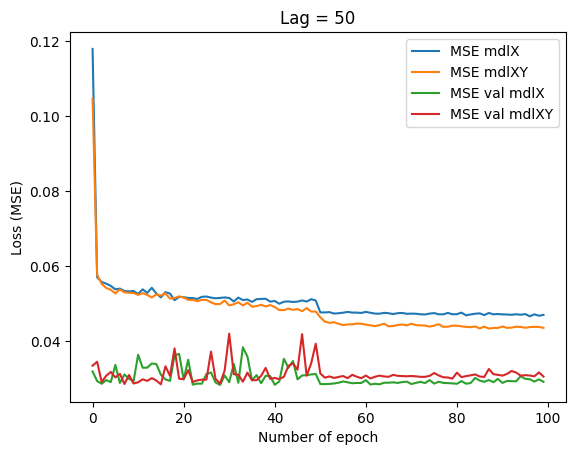

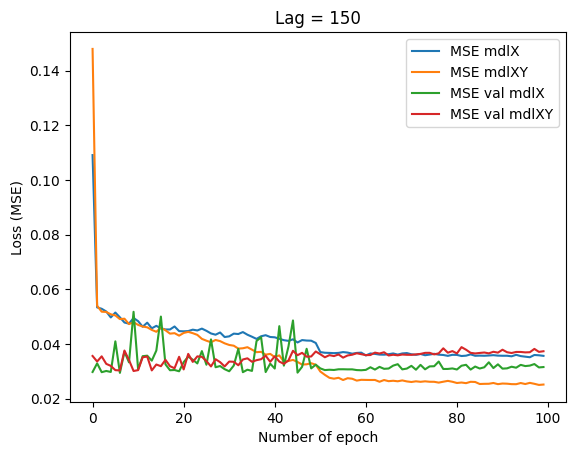

In [ ]:
#%% Example of obtaining the results

for lag in lags:
    best_model_X_lag50 = results[lag].best_model_X
    best_model_XY_lag50 = results[lag].best_model_XY

    p_value = results[lag].p_value
    test_statistic = results[lag].test_statistic

    best_history_X = results[lag].best_history_X
    best_history_XY = results[lag].best_history_XY

    nlc.plot_history_loss(best_history_X, best_history_XY)
    plt.title("Lag = %d" % lag)

    best_errors_X = results[lag].best_errors_X
    best_errors_XY = results[lag].best_errors_XY

    cohens_d = np.abs(
        (np.mean(np.abs(best_errors_X)) - np.mean(np.abs(best_errors_XY)))
        / np.std([best_errors_X, best_errors_XY])
    )
    print("For lag = %d Cohen's d = %0.3f" % (lag, cohens_d))
    print(f"test statistic = {test_statistic} p-value = {p_value}")

0->1
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3388 - mse: 0.3388 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0648 - mse: 0.0648 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0631 - mse: 0.0631 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0619 - mse: 0.0619 - val_loss: 0.0344 - val_mse: 0.0344
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0604 - mse: 0.0604 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0597 - mse: 0.0597 - val_loss: 0.0331 - val_mse: 0.0331
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - los

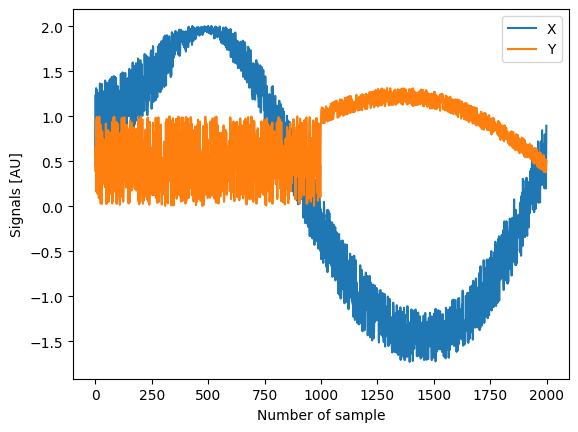

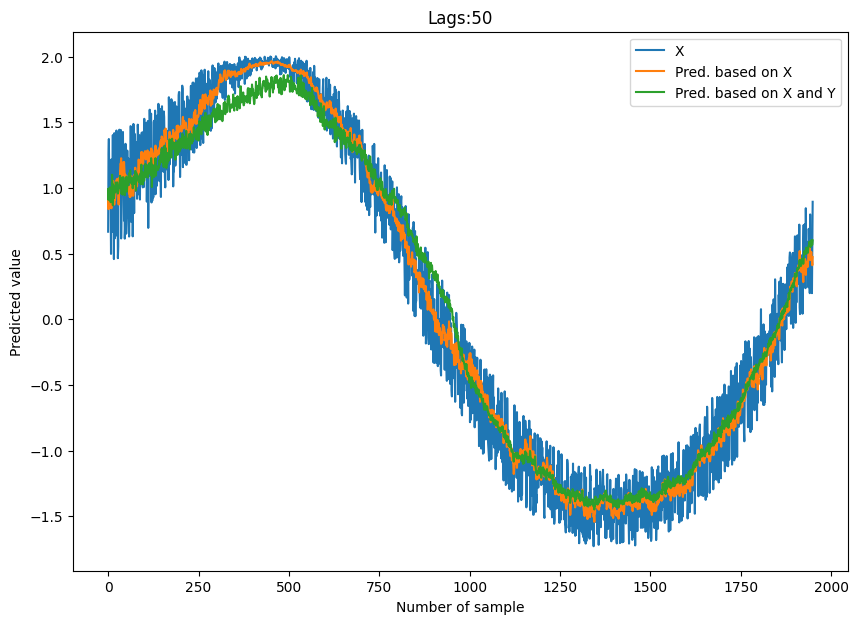

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2324 - mse: 0.2324 - val_loss: 0.0656 - val_mse: 0.0656
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0660 - mse: 0.0660 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0537 - mse: 0.0537 - val_loss: 0.0302 - val_mse: 0.0302
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0533 - mse: 0.0533 - val_loss: 0.0293 - val_mse: 0.0293
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0529 - mse: 0.0529 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0520 - mse: 0.0520 - val_loss: 0.0310 - val_mse: 0.0310
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0518 - mse: 0.0518 - val_loss: 0.0307 - val_mse: 0.0307
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

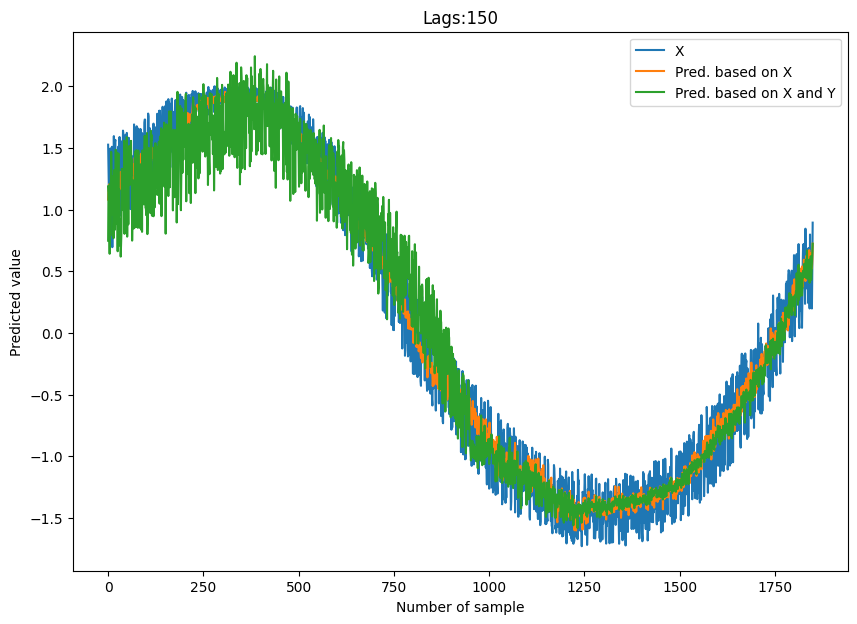

58/58 [==============================] - 0s 2ms/step
1->0
Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.0451 - mse: 0.0451 - val_loss: 0.0479 - val_mse: 0.0479
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0061 - mse: 0.0061 - val_loss: 0.0359 - val_mse: 0.0359
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0348 - val_mse: 0.0348
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0343 - val_mse: 0.0343
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0338 - val_mse: 0.0338
Epoch 8/50
186/186

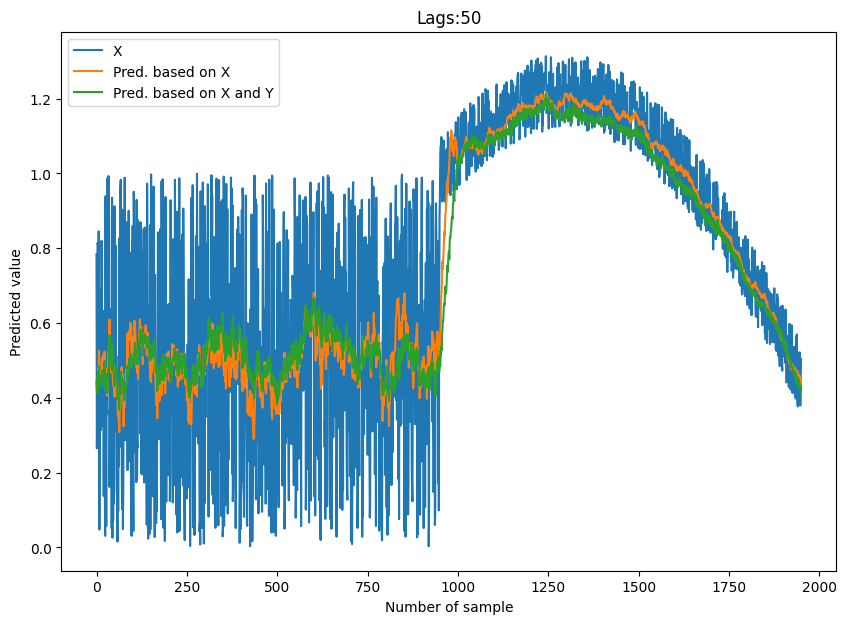

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.0626 - mse: 0.0626 - val_loss: 0.0935 - val_mse: 0.0935
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0115 - mse: 0.0115 - val_loss: 0.0669 - val_mse: 0.0669
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0078 - mse: 0.0078 - val_loss: 0.0411 - val_mse: 0.0411
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0308 - val_mse: 0.0308
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0296 - val_mse: 0.0296
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0286 - val_mse: 0.0286
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0048 - mse: 0.0048 - val_loss: 0.0284 - val_mse: 0.0284
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

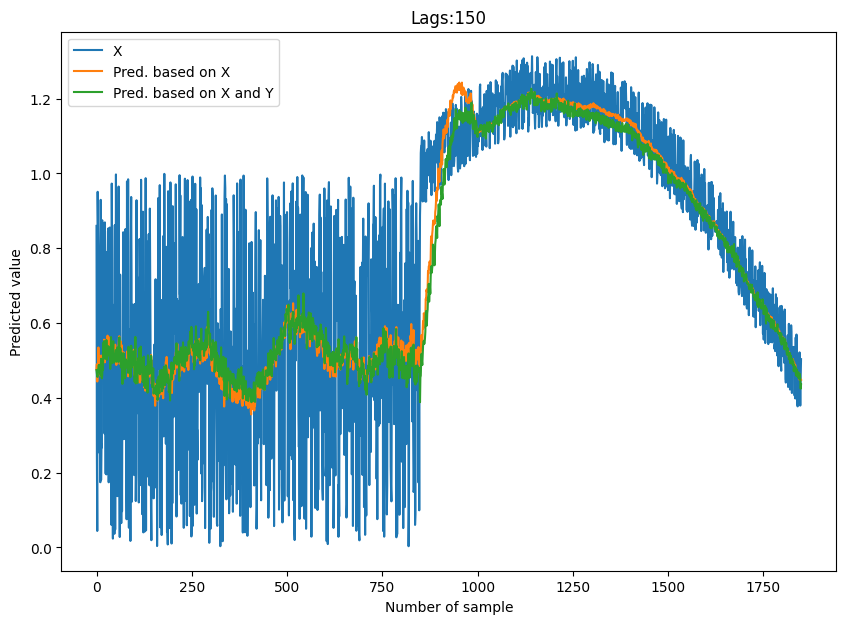

58/58 [==============================] - 0s 2ms/step


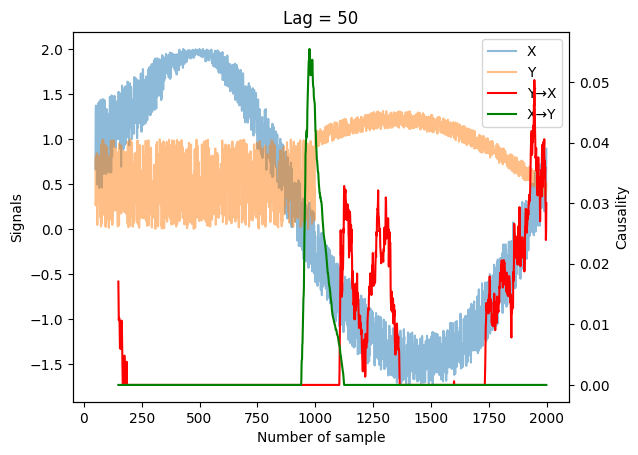

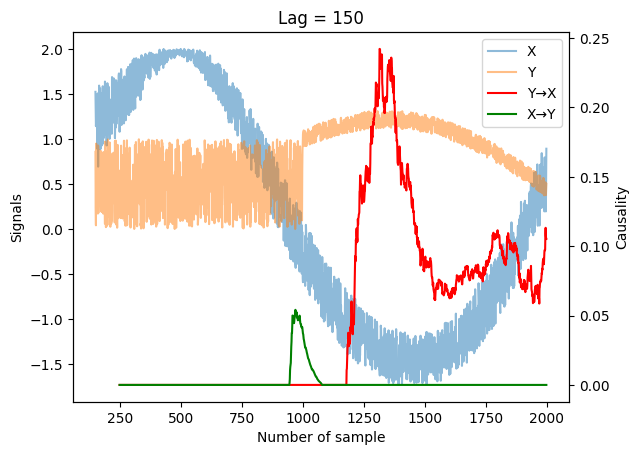

In [ ]:
#%% Example of the measure of the causality change over time

data_test_measure = copy.copy(data_test)
np.random.seed(30)
data_test_measure[:1000, 1] = np.random.random(1000)

plt.figure()
plt.plot(data_test_measure[:, 0], label="X")
plt.plot(data_test_measure[:, 1], label="Y")
plt.xlabel("Number of sample")
plt.ylabel("Signals [AU]")
plt.legend()

results = nlc.nonlincausalitymeasureNN(
    x=data_train,
    maxlag=lags,
    window=100,
    step=1,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test_measure,
    run=3,
    epochs_num=[50,50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    verbose=True,
    plot=True,
)

Epoch 1/50
186/186 [==============================] - 1s 5ms/step - loss: 0.3035 - mse: 0.3035 - val_loss: 0.0394 - val_mse: 0.0394
Epoch 2/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0649 - mse: 0.0649 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 3/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0637 - mse: 0.0637 - val_loss: 0.0366 - val_mse: 0.0366
Epoch 4/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0624 - mse: 0.0624 - val_loss: 0.0352 - val_mse: 0.0352
Epoch 5/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0607 - mse: 0.0607 - val_loss: 0.0336 - val_mse: 0.0336
Epoch 6/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0593 - mse: 0.0593 - val_loss: 0.0379 - val_mse: 0.0379
Epoch 7/50
186/186 [==============================] - 1s 4ms/step - loss: 0.0581 - mse: 0.0581 - val_loss: 0.0321 - val_mse: 0.0321
Epoch 8/50
186/186 [==============================] - 1s 4ms/step - loss: 0.

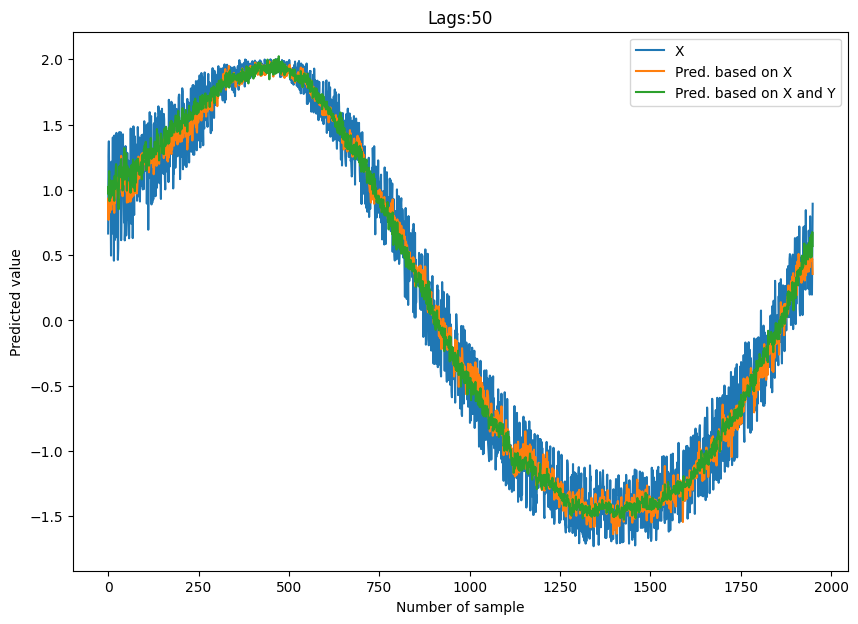

Epoch 1/50
183/183 [==============================] - 1s 6ms/step - loss: 0.2464 - mse: 0.2464 - val_loss: 0.0697 - val_mse: 0.0697
Epoch 2/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0676 - mse: 0.0676 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 3/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0313 - val_mse: 0.0313
Epoch 4/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0535 - mse: 0.0535 - val_loss: 0.0328 - val_mse: 0.0328
Epoch 5/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0536 - mse: 0.0536 - val_loss: 0.0322 - val_mse: 0.0322
Epoch 6/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0526 - mse: 0.0526 - val_loss: 0.0332 - val_mse: 0.0332
Epoch 7/50
183/183 [==============================] - 1s 5ms/step - loss: 0.0522 - mse: 0.0522 - val_loss: 0.0325 - val_mse: 0.0325
Epoch 8/50
183/183 [==============================] - 1s 5ms/step - loss: 0.

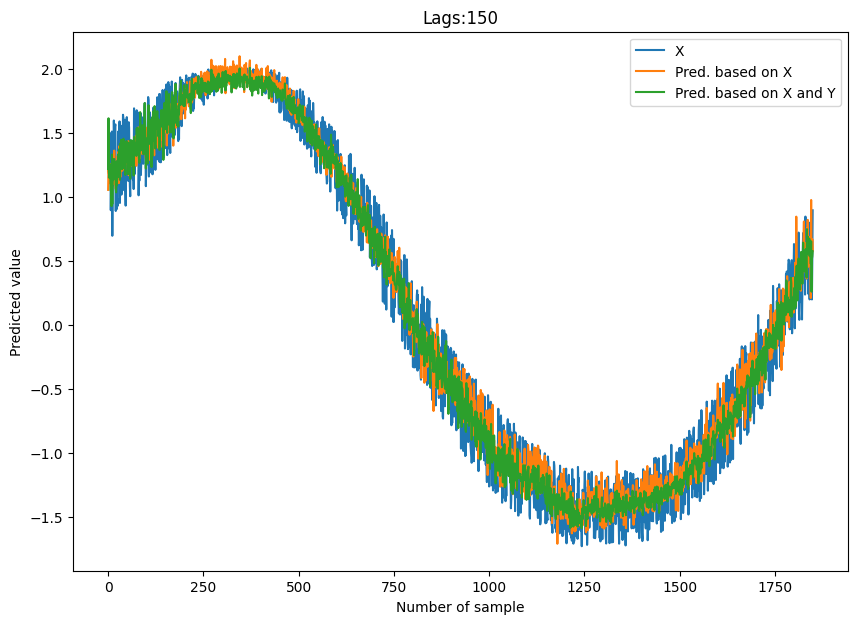

In [ ]:
#%% Example of usage for conditional analysis

np.random.seed(30)
z = np.random.random([10_000, 2])

z_train = z[:6000, :]
z_val = z[6000:8000, :]
z_test = z[8000:, :]

results_conditional = nlc.nonlincausalityNN(
    x=data_train,
    maxlag=lags,
    NN_config=['d','dr','d','dr'],
    NN_neurons=[100,0.05,100,0.05],
    x_test=data_test,
    run=1,
    z=z_train,
    z_test=z_test,
    epochs_num=[50, 50],
    learning_rate=[0.0001, 0.00001],
    batch_size_num=32,
    x_val=data_val,
    z_val=z_val,
    reg_alpha=None,
    callbacks=None,
    verbose=True,
    plot=True,
)

Statistics value = 1042424.0 p-value = 0.00012035170468659112


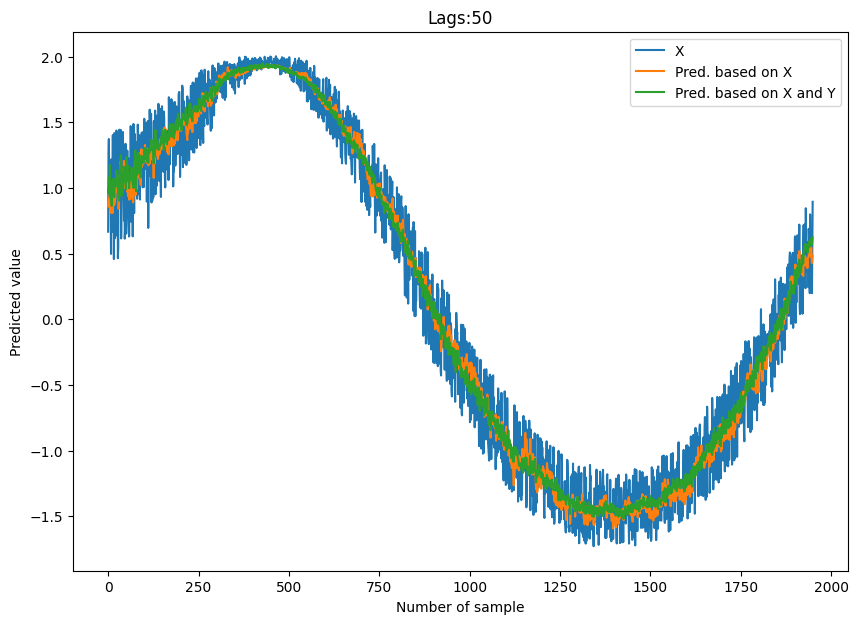

Statistics value = 1099413.0 p-value = 1.6802747241548963e-26


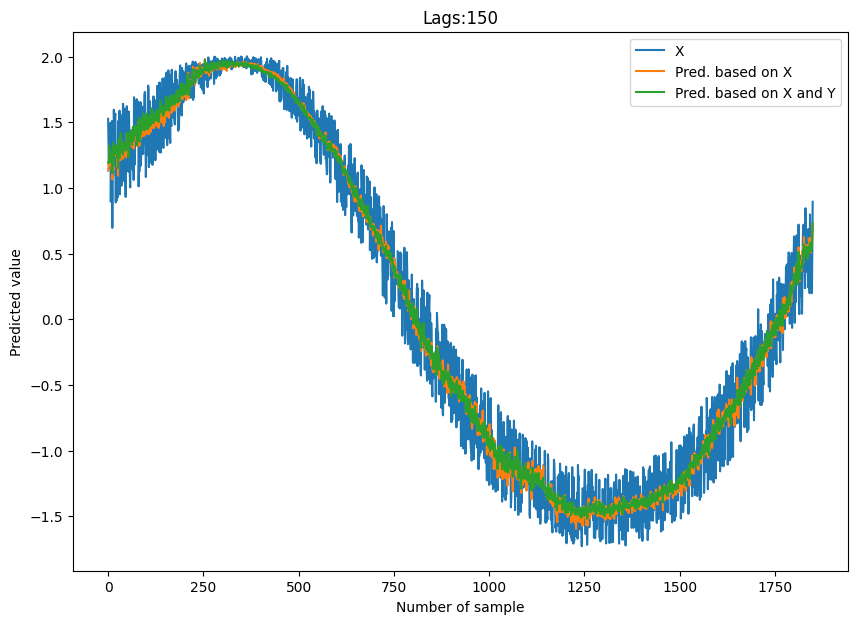

In [ ]:
# %% Exaple of the usage the package with Scikit-learn model

parametres = {
    'kernel':['poly', 'rbf'],
    'C':[0.01,0.1,1], 
    'epsilon':[0.01,0.1,1.]
}
results_skl = nlc.nonlincausality_sklearn(    
    x=data_train,
    sklearn_model=SVR,
    maxlag=lags,
    params=parametres,
    x_test=data_test,
    x_val=data_val,
    plot=True)

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 9449.0 p-value = 0.3566899541578241


/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


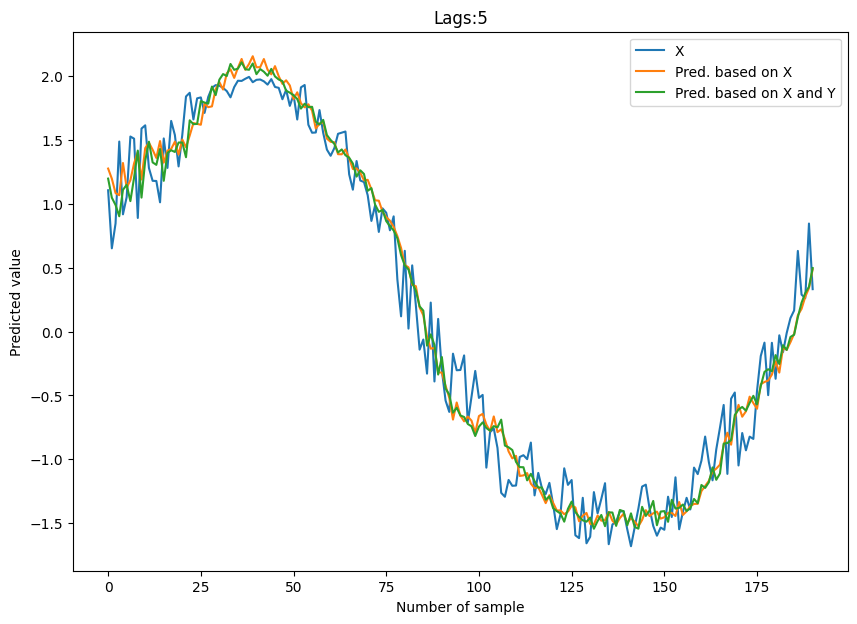

/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/root/miniconda3/envs/cs1/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Statistics value = 8785.0 p-value = 0.013597302548135959


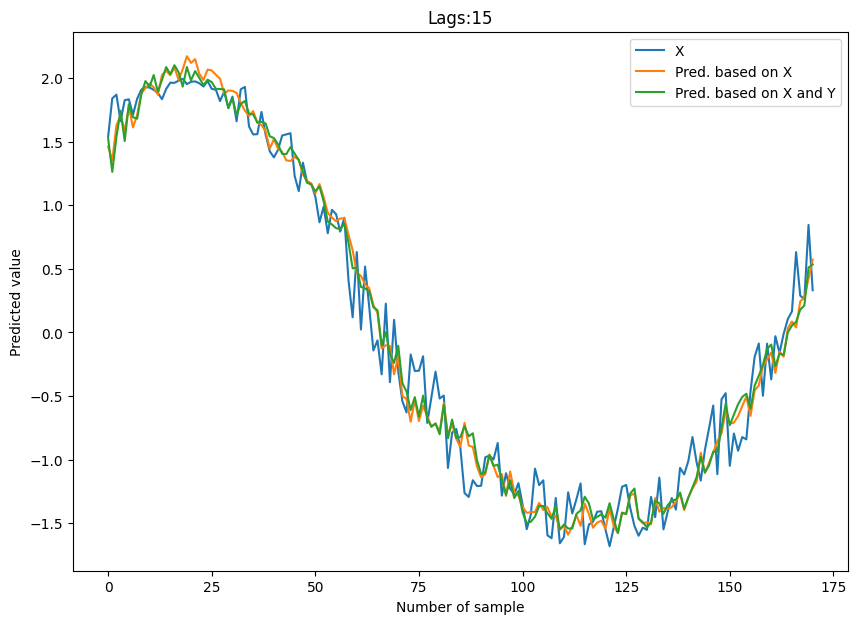

In [ ]:
#%% Example of usage other functions for causality analysis

# ARIMA/ARIMAX models
results_ARIMA = nlc.nonlincausalityARIMA(x=data_train[::10], maxlag=[5,15], x_test=data_test[::10])